### Load an image and pass it to a model

In [1]:
from skimage import io, img_as_float, img_as_ubyte
import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

In [70]:
minutes = 15
#def name_to_hrs (r): return float(round(float(os.path.basename(r)[0:-4].split("_")[1][1:])*(minutes/60)+5,2))
def name_to_hrs (r): return float(round(float(os.path.basename(r)[0:-4].split("_")[1][1:])*(minutes/60)+5,2))
time = name_to_hrs('D:/pytorch/data/2D_FishAge_pytorch/images/S000_t000028_V000_R0005_X000_Y000_C02_I0_D0_P00344_MP.tif')
device = 'cuda'

In [71]:
time
#model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8, pretrained=True)

12.0

In [72]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=1, out_channels=1, init_features=8, pretrained=False)
#add layers
class regression_net(nn.Module):
    def __init__(self):
        super(regression_net, self).__init__()
        self.conv1 = nn.Conv2d(1,1,kernel_size=(1, 1), stride=(1, 1))
        self.pool = nn.AdaptiveAvgPool2d((32,32))
        self.fc = nn.Linear(1024, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x= torch.flatten(x, 1)
        #print(x.shape)
        #Final age should be between 5 and 24 hours
        x = 4.9+torch.sigmoid(self.fc(x))*19.1 
        #print(x.shape)
        #x = F.leaky_relu(self.fc(x))

        return x

regnet = regression_net()
model = nn.Sequential(model, regnet)
model.to(device)

Using cache found in C:\Users\MichaelSNelson/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


Sequential(
  (0): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNorm2d(16

In [73]:
model.to(device)
input = torch.from_numpy( img )[None, None, :].float()
input = input.to('cuda')
output = model(input)
output.shape

torch.Size([1, 1])

In [74]:
output

tensor([[14.4690]], device='cuda:0', grad_fn=<AddBackward0>)

In [75]:
model.train()
#def loss_fn (output, target): return 0.5*(output- target)**2
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # 0.0001

In [76]:
# imgs = glob('D:/pytorch/data/2D_Zebrafish/images/*.tif')
# ages = [name_to_hrs(o) for o in masks]
# for i, (img, age) in enumerate(zip(imgs, ages)):
#     img = img_as_float(io.imread(img))
#     input = torch.from_numpy( img ).unsqueeze(0).unsqueeze(0).float().cuda()
#     target = age
#     output = model(input)
#     loss = loss_fn(output, target)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     loss, current = loss.item(), i
#     print(f"loss: {loss:>7f}  [{current:>5d}/{len(imgs):>5d}]")

### use dataloader

In [77]:
# class ImageMaskPair(Dataset):
#     def __init__(self, img_paths, mask_paths, transforms=None):
#         self.img_paths = img_paths
#         self.mask_paths = mask_paths
#         if transforms is not None:
#             self.transforms = transforms

#     def __len__(self):
#         return len(self.img_paths)

#     def __getitem__(self, idx):
#         img = img_as_float(io.imread(self.img_paths[idx]))
#         mask = img_as_float(io.imread(self.mask_paths[idx]))
#         mask[mask>0] = 1
#         # img = torch.from_numpy( img )[None, :].float() # C x H x W
#         # mask = torch.from_numpy( mask )[None, :].float() # C x H x W
#         img = self.transforms(img)
#         mask = self.transforms(mask)
#         return img, mask

In [193]:
pair_transforms = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Resize((512,512)),
    transforms.Normalize(mean = 0.5, std=0.5),
    #transforms.ColorJitter(contrast = 0.2),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomApply([transforms.RandomRotation((90,90))], p=0.5)

])

In [194]:
class ImageValuePair(Dataset):
    def __init__(self, img_paths, transforms=None):
        self.img_paths = img_paths
        
        if transforms is not None:
            self.transforms = transforms

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = img_as_float(io.imread(self.img_paths[idx]))
        age = torch.tensor(name_to_hrs(self.img_paths[idx]))
        img = self.transforms(img)
        return img, age

In [195]:
device = 'cuda'
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.view(-1,1)
        #print(X[200:250, 200:250])
        # Compute prediction error
        pred = model(X)

        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(pred)
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            N = len(X)
            #print(batchLen)
            X, y = X.to(device), y.to(device)
            pred = model(X) # N x 1 x H x W
            test_loss += loss_fn(pred, y).item()
            #print(f"Actual:{y:>8f} \n Pred: {pred:>8f} \n")
    test_loss /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [196]:
img_train_paths = glob('D:/pytorch/data/2D_FishAge_pytorch/images/*.tif')
img_test_paths = glob('D:/pytorch/data/2D_FishAge_pytorch/testimages/*.tif')


In [197]:
image_train = ImageValuePair(img_train_paths,  transforms=pair_transforms)
train_dataloader = DataLoader(image_train, batch_size=2, shuffle=True)
image_test= ImageValuePair(img_test_paths, transforms=pair_transforms)
test_dataloader = DataLoader(image_test, batch_size=2, shuffle=True)

In [198]:
train_images = next(iter(test_dataloader))

Feature batch shape: torch.Size([2, 1, 512, 512])


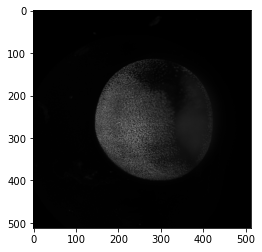

tensor([12.0524], device='cuda:0', grad_fn=<SelectBackward0>)


In [199]:
#pick an image to view
n=1

train_images, train_ages= next(iter(test_dataloader))
agesout = model(train_images.cuda())
print(f"Feature batch shape: {train_images.size()}")
img = train_images[n].squeeze()

plt.imshow(img, cmap="gray")
plt.show()
print(agesout[n])

In [170]:
train_ages

tensor([ 8.2500, 10.0000])

In [171]:

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2) # 0.0001
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
tensor([[11.6918],
        [11.6918]], device='cuda:0', grad_fn=<AddBackward0>)
loss: 5.058183  [    0/ 1080]
tensor([[11.8861],
        [11.8862]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.6908],
        [11.6908]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.4995],
        [11.4995]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.6884],
        [11.6884]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.6884],
        [11.6884]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.6884],
        [11.6884]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.6884],
        [11.6884]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.6884],
        [11.6884]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.4981],
        [11.4981]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[11.6859],
        [11.6859]], device='cuda:0', grad_fn=<AddBackward0>)
loss: 3.189073  [   20/ 1080]
tensor([[11.8787],
 

KeyboardInterrupt: 